# Featurization

This notebook is intended to featurize the data associated with human CRISPRi activity scores to make it easier to train a linear regression model to.

The data used is that from the following paper:

[Compact and highly active next-generation libraries for CRISPR-mediated gene repression and activation](https://elifesciences.org/articles/19760)

__Authors__: Anthony Hein, Briana Macedo, Manya Kapoor

---

###  _TODO: Create similar contribution graph_
### _TODO:  Z-standardize all numerical data__


__Bold == Featurized!__

Features available from data:
- __Distance to TSS (primary and secondary, downstream and upstream)__
- __sgRNA length__
- __(+) or (-) stranded sgRNA__
- __Longest consecutive run of each base__
- __Overall nucleotide composition (% of A, C, T, G, GC, CA, AG)__
- __Nucleotides at each position__
- __Nucleotides dimers at each position__

Features unavailable (stretch goal):
- DNAse-seq signal
- MNase-seq signal
- FAIRE-seq signal
- sgRNA overall folding free energy
- RNA pairing at each position





---

# Notebook Setup

In [82]:
# dataframes
import pandas as pd

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# regression & support vector machine
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# random seed
np.random.seed(0)

# plotting
%matplotlib inline

---

# Data Imports and Checks

In [3]:
# read csvs into dfs & inspect
activity_score_df = pd.read_csv('CRISPRi_Activity_Score_Data.csv')
tss_annotation_df = pd.read_csv('TSS_Annotations.csv')

### Activity Score Dataframe Checks

In [4]:
activity_score_df.head()

,gene symbol,chromosome,PAM genomic coordinate [hg19],strand targeted,sgRNA length (including PAM),sgRNA sequence,"CRISPRi activity score [Horlbeck et al., eLife 2016]"
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [5]:
activity_score_df.info

<bound method DataFrame.info of       gene symbol chromosome  PAM genomic coordinate [hg19] strand targeted  \
0            AARS      chr16                       70323441               +   
1            AARS      chr16                       70323216               +   
2            AARS      chr16                       70323296               +   
3            AARS      chr16                       70323318               +   
4            AARS      chr16                       70323362               +   
5            AARS      chr16                       70323225               -   
6            AARS      chr16                       70323276               -   
7            AARS      chr16                       70323332               -   
8            AARS      chr16                       70323472               -   
9            AARS      chr16                       70323466               +   
10           AARS      chr16                       70323196               +   
11           AARS   

In [6]:
activity_score_df.dtypes

gene symbol                                              object
chromosome                                               object
PAM genomic coordinate [hg19]                             int64
strand targeted                                          object
sgRNA length (including PAM)                              int64
sgRNA sequence                                           object
CRISPRi activity score [Horlbeck et al., eLife 2016]    float64
dtype: object

### TSS Annotation Dataframe Checks

In [7]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,TSS source,"Primary TSS, 5'","Primary TSS, 3'","Secondary TSS, 5'","Secondary TSS, 3'"
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


In [8]:
tss_annotation_df.info

<bound method DataFrame.info of                   gene              transcript chromosome strand  \
0                 A1BG                      P1      chr19      -   
1                 A1BG                      P2      chr19      -   
2                 A1CF                    P1P2      chr10      -   
3                  A2M                    P1P2      chr12      -   
4                A2ML1                    P1P2      chr12      +   
5              A3GALT2       ENST00000442999.3       chr1      -   
6               A4GALT                    P1P2      chr22      -   
7                A4GNT                    P1P2       chr3      -   
8                 AAAS                    P1P2      chr12      -   
9                 AACS                    P1P2      chr12      +   
10               AADAC                    P1P2       chr3      +   
11             AADACL2                    P1P2       chr3      +   
12             AADACL3                    P1P2       chr1      +   
13             A

In [9]:
tss_annotation_df.dtypes

gene                 object
transcript           object
chromosome           object
strand               object
TSS source           object
Primary TSS, 5'       int64
Primary TSS, 3'       int64
Secondary TSS, 5'     int64
Secondary TSS, 3'     int64
dtype: object

### Column Renaming (for convenience)

In [10]:
new_colnames = {
    "gene symbol" : "gene",
    "PAM genomic coordinate [hg19]" : "coordinate",
    "strand targeted" : "strand",
    "sgRNA length (including PAM)" : "length",
    "sgRNA sequence" : "sequence",
    "CRISPRi activity score [Horlbeck et al., eLife 2016]" : "score"
}
activity_score_df = activity_score_df.rename(columns=new_colnames)

In [11]:
activity_score_df.head()

,gene,chromosome,coordinate,strand,length,sequence,score
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154


In [12]:
new_colnames = {
    "TSS source" : "source",
    "Primary TSS, 5'" : "prim 5'",
    "Primary TSS, 3'" : "prim 3'",
    "Secondary TSS, 5'" : "snd 5'",
    "Secondary TSS, 3'" : "snd 3'"
}
tss_annotation_df = tss_annotation_df.rename(columns=new_colnames)

In [13]:
tss_annotation_df.head()

,gene,transcript,chromosome,strand,source,prim 5',prim 3',snd 5',snd 3'
0,A1BG,P1,chr19,-,"CAGE, matched peaks",58858938,58859039,58858938,58859039
1,A1BG,P2,chr19,-,"CAGE, matched peaks",58864822,58864847,58864822,58864847
2,A1CF,P1P2,chr10,-,"CAGE, matched peaks",52645379,52645393,52645379,52645393
3,A2M,P1P2,chr12,-,"CAGE, matched peaks",9268507,9268523,9268528,9268542
4,A2ML1,P1P2,chr12,+,"CAGE, matched peaks",8975206,8975223,8975144,8975169


### Standardize Data (for convenience)

In [14]:
# capitalize all sequences
activity_score_df['sequence'] = activity_score_df['sequence'].str.upper()

# map strands {-, +} --> {0, 1}
activity_score_df['+ve strand'] = (activity_score_df['strand'] == '+').astype('int')

In [15]:
activity_score_df.head()

,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand
0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1
1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1
2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1
3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1
4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1


### Cross-Check the Dataframes

During our analysis, we realized the following:

Genes in `tss_annotation_df` may _not_ be unique. Rather, the product of a gene and a transcript is unique. However, there is no transcript information contained within `activity_score_df`. For this reason, if a gene appears in `activity_score_df` that does not correspond to a unique gene in `tss_annotation_df`, it becomes ambiguous which one to use. Given that these constitute a relatively small set, we have chosen to remove these from `activity_score_df`.

A gene in `activity_score_df` may not have an annotation in `tss_annotation_df`. Once again, these constitute a small set, so we remove them.
The following cells implement these fixes.

_NB: A future iteration of this notebook might find ways to better address these ambiguities._

In [16]:
# genes are duplicated in tss_annotation_df
annot_genes_dup_vec = tss_annotation_df['gene'].duplicated()
print(str(sum(annot_genes_dup_vec)) + " genes are duplicated in tss_annotation_df")

1694 genes are duplicated in tss_annotation_df


In [17]:
# the set of duplicated genes
annot_genes_dup = tss_annotation_df['gene'][annot_genes_dup_vec].unique()
print("The following are some of the genes duplicated in tss_annotation_df: " + str(annot_genes_dup[0:5]))

The following are some of the genes duplicated in tss_annotation_df: ['A1BG' 'AARSD1' 'ABAT' 'ABCA7' 'ABCB9']


In [18]:
# genes in activity_score_df that occur in this set are ambiguous
ambiguous_gene_vec = np.isin(activity_score_df['gene'], annot_genes_dup)
print(str(sum(ambiguous_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(ambiguous_gene_vec) * 100)) + 
      "%) of genes in activity_score_df have ambigiuous annotations.")

1113 (or about 6%) of genes in activity_score_df have ambigiuous annotations.


In [19]:
# print ambiguous genes
ambiguous_genes = activity_score_df['gene'][ambiguous_gene_vec].unique()
print("Ambiguous genes are: " + str(ambiguous_genes))

Ambiguous genes are: ['ATP5A1' 'ATP5J2-PTCD1' 'BCL2L1' 'BOD1L1' 'C11orf45' 'CANX' 'CBFA2T3'
 'CCNK' 'CDK6' 'CENPA' 'CKAP5' 'COPS7B' 'COPZ1' 'DDX46' 'DDX54' 'DHODH'
 'DNASE1L1' 'DPH1' 'DYNLRB1' 'EEF2' 'EIF4G2' 'ESF1' 'FBXO8' 'FDFT1' 'FIS1'
 'FOLR3' 'GON4L' 'HAUS7' 'HMG20B' 'IDH3A' 'IFT74' 'IK' 'IL11RA' 'KMT2B'
 'LDB1' 'LSM5' 'MAPKAP1' 'MRPL30' 'MTHFD2' 'NDUFC1' 'NDUFS5' 'NDUFV1'
 'OAZ3' 'PKM' 'PMPCB' 'PNISR' 'POLR1D' 'POLR2D' 'PPP2R1A' 'PRMT5' 'PSMB6'
 'PSPH' 'PTCD1' 'RAB5C' 'RBM4' 'RPS29' 'RSL1D1' 'SEC61A1' 'SF3A1'
 'SLC12A9' 'SLC1A5' 'SNW1' 'ST3GAL2' 'STAG2' 'TACC3' 'TAL1' 'TKT' 'TUBB'
 'UBA1' 'USP39' 'WBP11' 'ZMAT2' 'ZMYM3' 'ZNF574' 'ZNF699']


In [20]:
# remove these ambiguous genes
old_length = len(activity_score_df)
activity_score_df = activity_score_df[np.logical_not(ambiguous_gene_vec)]
new_length = len(activity_score_df)
activity_score_df = activity_score_df.reset_index()

assert (old_length - sum(ambiguous_gene_vec) == new_length)
assert (sum(np.isin(activity_score_df['gene'], annot_genes_dup)) == 0)

print("The ambigious genes have been removed.")

The ambigious genes have been removed.


In [21]:
# set of genes in tss_annotation_df
annot_genes = tss_annotation_df['gene'].unique()
print("The following are some of the genes in tss_annotation_df: " + str(annot_genes[0:5]))

The following are some of the genes in tss_annotation_df: ['A1BG' 'A1CF' 'A2M' 'A2ML1' 'A3GALT2']


In [22]:
# genes in activity_score_df that do not appear in this set are unkown
unknown_gene_vec = np.logical_not(np.isin(activity_score_df['gene'], annot_genes))
print(str(sum(unknown_gene_vec)) + 
      " (or about " + 
      str(int(np.mean(unknown_gene_vec) * 100)) + 
      "%) of genes in activity_score_df have unknown annotations.")

17 (or about 0%) of genes in activity_score_df have unknown annotations.


In [23]:
# print unknown genes
unknown_genes = activity_score_df['gene'][unknown_gene_vec].unique()
print("Ambiguous genes are: " + str(unknown_genes))

Ambiguous genes are: ['NIFK']


In [24]:
# remove these unknown genes
old_length = len(activity_score_df)
activity_score_df = activity_score_df[np.logical_not(unknown_gene_vec)]
new_length = len(activity_score_df)
activity_score_df = activity_score_df.reset_index()

assert (old_length - sum(unknown_gene_vec) == new_length)
assert (sum(np.isin(activity_score_df['gene'], annot_genes)) == new_length)

print("The unknown genes have been removed.")

The unknown genes have been removed.


In [25]:
activity_score_df

,level_0,index,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand
0,0,0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1
1,1,1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1
2,2,2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1
3,3,3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1
4,4,4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1
5,5,5,AARS,chr16,70323225,-,22,GGCTTCTCCAGGCCACGCG,0.579759,0
6,6,6,AARS,chr16,70323276,-,23,GAGCTTTCCCCCCAGTCTGC,0.008311,0
7,7,7,AARS,chr16,70323332,-,23,GAGGGCGGCCTACCTCTCCT,0.824812,0
8,8,8,AARS,chr16,70323472,-,23,GTCCAATCAGAGCGCGCCGA,0.004219,0
9,9,9,AARS,chr16,70323466,+,24,GCGCGGCGGGGCACTTTCCGT,-0.045817,1


---

# Feature: Longest Consecutive Run of Each Base 

In [26]:
def get_longest_consec(seq):
    """
    The function finds the longest consecutive run of each
    nucleotide base within a sequence in O(n).
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        4-tuple: the entries are the longest consecutive
        run of 'A', 'C', 'G', and 'T' in that order.
    """
    
    max_run = {'A': 0, 'C': 0, 'G': 0, 'T': 0}
    current_run = 0
    current_base = None

    for char in seq:
        if char == current_base:
            current_run += 1
        else:
            if current_base != None and current_run > max_run[current_base]:
                max_run[current_base] = current_run
            current_base = char
            current_run = 1
            
    return (max_run['A'], max_run['C'], max_run['G'], max_run['T'])

In [27]:
longest_consec_run_colnames = [
    'longest A',
    'longest C', 
    'longest G', 
    'longest T'
]

longest_consec_run_series = activity_score_df['sequence'].apply(get_longest_consec)

longest_consec_run_df = pd.DataFrame(longest_consec_run_series.tolist(), columns = longest_consec_run_colnames)

activity_score_df = pd.concat([activity_score_df, longest_consec_run_df], axis=1, sort=False)
activity_score_df

,level_0,index,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand,longest A,longest C,longest G,longest T
0,0,0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,1,1,2,2
1,1,1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,1,4,2,1
2,2,2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,1,3,2,1
3,3,3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,1,3,2,1
4,4,4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,1,3,3,2
5,5,5,AARS,chr16,70323225,-,22,GGCTTCTCCAGGCCACGCG,0.579759,0,1,2,2,2
6,6,6,AARS,chr16,70323276,-,23,GAGCTTTCCCCCCAGTCTGC,0.008311,0,1,6,1,3
7,7,7,AARS,chr16,70323332,-,23,GAGGGCGGCCTACCTCTCCT,0.824812,0,1,2,3,1
8,8,8,AARS,chr16,70323472,-,23,GTCCAATCAGAGCGCGCCGA,0.004219,0,2,2,1,1
9,9,9,AARS,chr16,70323466,+,24,GCGCGGCGGGGCACTTTCCGT,-0.045817,1,1,2,4,3


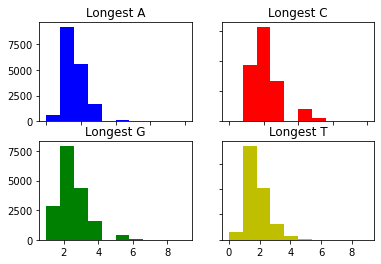

In [28]:
# look at longest consecutive run
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(activity_score_df['longest A'], color="b")
axs[0, 0].set_title('Longest A')
axs[0, 1].hist(activity_score_df['longest C'], color="r")
axs[0, 1].set_title('Longest C')
axs[1, 0].hist(activity_score_df['longest G'], color="g")
axs[1, 0].set_title('Longest G')
axs[1, 1].hist(activity_score_df['longest T'], color="y")
axs[1, 1].set_title('Longest T')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: sgRNA Length

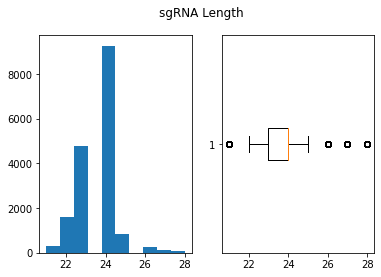

In [29]:
fig, axs = plt.subplots(1, 2)
fig.suptitle("sgRNA Length")


axs[0].hist(activity_score_df['length'])
axs[1].boxplot(activity_score_df['length'], vert=False)

plt.show()

---

# Feature: Nucleotides at Each Position

To maintain the nucleotide at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each position in the longest sequence. Necessarily, some cells will have empty spaces since not all sequences are of equal length.

In [30]:
# get each sequence as a string of the same length, right justified
max_len = max(activity_score_df['sequence'].str.len())
sequence_rjust = activity_score_df['sequence'].apply(lambda x : x.rjust(max_len))

In [52]:
sgRNA_bases = pd.DataFrame(sequence_rjust.apply(list).tolist())
sgRNA_bases['length'] = activity_score_df['sequence'].str.len()
sgRNA_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,length
0,,,,,G,C,G,C,T,C,...,G,A,C,G,G,A,G,C,G,21
1,,,,,G,C,C,C,C,A,...,G,G,C,C,C,C,G,C,G,21
2,,,,,G,G,C,C,G,C,...,A,G,A,G,C,T,C,T,G,21
3,,,,,G,A,C,G,G,C,...,A,G,G,A,G,A,G,G,T,21
4,,,,,G,G,T,G,C,A,...,C,C,T,T,G,G,C,G,G,21


In [72]:
nucl_prefix = dict()

for i in range(max_len):
    nucl_prefix[i] = "pos_" + str(i)

In [73]:
a = pd.DataFrame([25 * ['A'] + [0]], columns=sgRNA_bases.columns.tolist())
c = pd.DataFrame([25 * ['C'] + [0]], columns=sgRNA_bases.columns.tolist())
g = pd.DataFrame([25 * ['G'] + [0]], columns=sgRNA_bases.columns.tolist())
t = pd.DataFrame([25 * ['T'] + [0]], columns=sgRNA_bases.columns.tolist())
nucl_tmp = sgRNA_bases.append(a).append(c).append(g).append(t).replace(' ', np.nan)

In [75]:
nucl_onehot = pd.get_dummies(nucl_tmp, prefix=nucl_prefix, dummy_na = False)
nucl_onehot = nucl_onehot[nucl_onehot['length'] != 0]
nucl_onehot.head()

,length,pos_0_A,pos_0_C,pos_0_G,pos_0_T,pos_1_A,pos_1_C,pos_1_G,pos_1_T,pos_2_A,...,pos_22_G,pos_22_T,pos_23_A,pos_23_C,pos_23_G,pos_23_T,pos_24_A,pos_24_C,pos_24_G,pos_24_T
0,21,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,21,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
2,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,21,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4,21,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [36]:
# base_encodings = {
#     'A' : 0, 
#     'C' : 1, 
#     'G' : 2, 
#     'T' : 3, 
# }

# for base, repl in _base_encodings.items():
#     sgRNA_bases.replace(dimer, repl, inplace = True)
    
# sgRNA_bases.head()

---

# Feature: Nucleotide Composition

In [147]:
As = []
Cs = []
Gs = []
Ts = []

for index, row in sgRNA_bases.iterrows():
    length = row['length']
    As.append(sum(row == 'A') / length)
    Cs.append(sum(row == 'C') / length)
    Gs.append(sum(row == 'G') / length)
    Ts.append(sum(row == 'T') / length)
    
sgRNA_bases['As'] = As
sgRNA_bases['Cs'] = Cs
sgRNA_bases['Gs'] = Gs
sgRNA_bases['Ts'] = Ts

sgRNA_bases.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,length,As,Cs,Gs,Ts
0,,,,,G,C,G,C,T,C,...,G,A,G,C,G,21,0.142857,0.238095,0.428571,0.190476
1,,,,,G,C,C,C,C,A,...,C,C,G,C,G,21,0.142857,0.476190,0.333333,0.047619
2,,,,,G,G,C,C,G,C,...,C,T,C,T,G,21,0.095238,0.380952,0.380952,0.142857
3,,,,,G,A,C,G,G,C,...,G,A,G,G,T,21,0.238095,0.238095,0.428571,0.095238
4,,,,,G,G,T,G,C,A,...,G,G,C,G,G,21,0.047619,0.285714,0.523810,0.142857


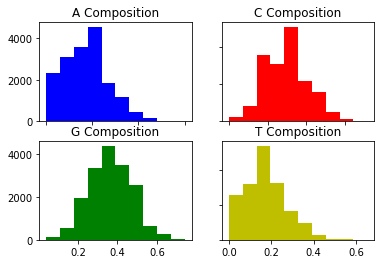

In [148]:
# look at nucleotide composition
fig, axs = plt.subplots(2, 2)

axs[0, 0].hist(sgRNA_bases['As'], color="b")
axs[0, 0].set_title('A Composition')
axs[0, 1].hist(sgRNA_bases['Cs'], color="r")
axs[0, 1].set_title('C Composition')
axs[1, 0].hist(sgRNA_bases['Gs'], color="g")
axs[1, 0].set_title('G Composition')
axs[1, 1].hist(sgRNA_bases['Ts'], color="y")
axs[1, 1].set_title('T Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: Dimers at Each Position

Similarly, to maintain the dimer at each position, we will create a new dataframe with one row for every sgRNA sequence in `activity_scores_df` and one column for each dimer position in the longest sequence. Necessarily, some columns will have `None` since not all sequences are of equal length.

In [39]:
def get_seq_dimers(seq):
    """
    This function returns the dimers of an input sequence
    as a list of two-character strings.
    
    Args:
        seq (str): The sgRNA sequence.

    Returns:
        list: the entry at position i is the ith dimer,
        captured as a two-character string.
    """
    return [seq[i:i+2] for i in range(0, len(seq)-1)]

In [56]:
# NOTE BUG: Gettting some single nucleotides at the ends
# If odd number of positions, ignore last guy
max_dimer_len = max_len - 1
sequence_rjust = activity_score_df['sequence'].apply(lambda x : x.rjust(max_len))
sgRNA_dimers = pd.DataFrame(sequence_rjust.apply(get_seq_dimers).tolist())

# subtract one b/c one fewer dimers than bases
sgRNA_dimers['length'] = activity_score_df['sequence'].str.len() - 1

sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,length
0,,,,G,GC,CG,GC,CT,TC,CT,...,GG,GA,AC,CG,GG,GA,AG,GC,CG,20
1,,,,G,GC,CC,CC,CC,CA,AG,...,AG,GG,GC,CC,CC,CC,CG,GC,CG,20
2,,,,G,GG,GC,CC,CG,GC,CC,...,GA,AG,GA,AG,GC,CT,TC,CT,TG,20
3,,,,G,GA,AC,CG,GG,GC,CG,...,TA,AG,GG,GA,AG,GA,AG,GG,GT,20
4,,,,G,GG,GT,TG,GC,CA,AG,...,CC,CC,CT,TT,TG,GG,GC,CG,GG,20


In [63]:
prefix = dict()
for i in range(max_dimer_len):
    prefix[i] = "pos_" + str(i)

In [61]:
dimer_encodings = {'AA' : 0, 'AC' : 1, 'AG' : 2, 'AT' : 3, 'CA' : 4, 'CC' : 5, 'CG' : 6, 'CT' : 7,          
                   'GA' : 8, 'GC' : 9, 'GG' : 10, 'GT' : 11, 'TA' : 12, 'TC' : 13, 'TG' : 14, 'TT' : 15}
dummy_dimers = []
tmp = pd.DataFrame()
tmp = tmp.append(sgRNA_dimers)

for dimer in dimer_encodings.keys():
    dummy_dimers.append(pd.DataFrame([max_dimer_len * [dimer] + [0]], columns=sgRNA_dimers.columns.tolist()))
for df in dummy_dimers:
    tmp = tmp.append(df)

incomplete_dimers = ['  ', ' A', ' C', ' G', ' T']
    
tmp = tmp.replace(incomplete_dimers, np.nan)
tmp.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,length
0,NaN,NaN,NaN,NaN,GC,CG,GC,CT,TC,CT,...,GG,GA,AC,CG,GG,GA,AG,GC,CG,20
1,NaN,NaN,NaN,NaN,GC,CC,CC,CC,CA,AG,...,AG,GG,GC,CC,CC,CC,CG,GC,CG,20
2,NaN,NaN,NaN,NaN,GG,GC,CC,CG,GC,CC,...,GA,AG,GA,AG,GC,CT,TC,CT,TG,20
3,NaN,NaN,NaN,NaN,GA,AC,CG,GG,GC,CG,...,TA,AG,GG,GA,AG,GA,AG,GG,GT,20
4,NaN,NaN,NaN,NaN,GG,GT,TG,GC,CA,AG,...,CC,CC,CT,TT,TG,GG,GC,CG,GG,20


In [67]:
dimer_onehot = pd.get_dummies(tmp, prefix=prefix, dummy_na = False)
dimer_onehot.head()

,length,pos_0_AA,pos_0_AC,pos_0_AG,pos_0_AT,pos_0_CA,pos_0_CC,pos_0_CG,pos_0_CT,pos_0_GA,...,pos_23_CG,pos_23_CT,pos_23_GA,pos_23_GC,pos_23_GG,pos_23_GT,pos_23_TA,pos_23_TC,pos_23_TG,pos_23_TT
0,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [70]:
dimer_onehot = dimer_onehot[dimer_onehot['length'] != 0]
dimer_onehot.head()

,length,pos_0_AA,pos_0_AC,pos_0_AG,pos_0_AT,pos_0_CA,pos_0_CC,pos_0_CG,pos_0_CT,pos_0_GA,...,pos_23_CG,pos_23_CT,pos_23_GA,pos_23_GC,pos_23_GG,pos_23_GT,pos_23_TA,pos_23_TC,pos_23_TG,pos_23_TT
0,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,20,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [41]:
# dimer_encodings = {
#     'AA' : 0, 
#     'AC' : 1, 
#     'AG' : 2, 
#     'AT' : 3, 
#     'CA' : 4, 
#     'CC' : 5, 
#     'CG' : 6, 
#     'CT' : 7,          
#     'GA' : 8, 
#     'GC' : 9, 
#     'GG' : 10, 
#     'GT' : 11, 
#     'TA' : 12, 
#     'TC' : 13, 
#     'TG' : 14, 
#     'TT' : 15
# }

# for dimer, repl in encodings.items():
#     sgRNA_dimers.replace(dimer, repl, inplace = True)
    
# sgRNA_dimers.head()

---

# Feature: Dimer Composition

In [149]:
# Relevant dimers that the paper decsribes: GC, CA, AG
GC = []
CA = []
AG = []

for index, row in sgRNA_dimers.iterrows():
    length = row['length']
    GC.append(sum(row == 'GC') / length)
    CA.append(sum(row == 'CA') / length)
    AG.append(sum(row == 'AG') / length)

sgRNA_dimers['GC'] = GC
sgRNA_dimers['CA'] = CA
sgRNA_dimers['AG'] = AG
              
sgRNA_dimers.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,length,GC,CA,AG
0,,,,G,GC,CG,GC,CT,TC,CT,...,CG,GG,GA,AG,GC,CG,20,0.15,0.00,0.05
1,,,,G,GC,CC,CC,CC,CA,AG,...,CC,CC,CC,CG,GC,CG,20,0.15,0.10,0.10
2,,,,G,GG,GC,CC,CG,GC,CC,...,AG,GC,CT,TC,CT,TG,20,0.15,0.00,0.10
3,,,,G,GA,AC,CG,GG,GC,CG,...,GA,AG,GA,AG,GG,GT,20,0.05,0.00,0.15
4,,,,G,GG,GT,TG,GC,CA,AG,...,TT,TG,GG,GC,CG,GG,20,0.20,0.05,0.05


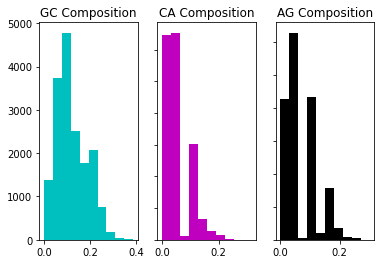

In [43]:
# look at nucleotide composition
fig, axs = plt.subplots(1, 3)

axs[0].hist(sgRNA_dimers['GC'], color="c")
axs[0].set_title('GC Composition')
axs[1].hist(sgRNA_dimers['CA'], color="m")
axs[1].set_title('CA Composition')
axs[2].hist(sgRNA_dimers['AG'], color="k")
axs[2].set_title('AG Composition')

for ax in fig.get_axes():
    ax.label_outer()

---

# Feature: Distances to TSS Sites

In [44]:
primary_five = []
primary_three = []
secondary_five = []
secondary_three = []

annot_genes = tss_annotation_df['gene']

for index, row in activity_score_df.iterrows():
    
    gene = row['gene']
    PAM_coord = row['coordinate']
    
    primary_five.append(tss_annotation_df["prim 5'"][annot_genes == gene].values[0] - PAM_coord)
    primary_three.append(tss_annotation_df["prim 3'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_five.append(tss_annotation_df["snd 5'"][annot_genes == gene].values[0] - PAM_coord)
    secondary_three.append(tss_annotation_df["snd 3'"][annot_genes == gene].values[0] - PAM_coord)
    
activity_score_df["dist prim 5'"] = primary_five
activity_score_df["dist prim 3'"] = primary_three
activity_score_df["dist snd 5'"] = secondary_five
activity_score_df["dist snd 3'"] = secondary_three

In [45]:
activity_score_df.head()

,level_0,index,gene,chromosome,coordinate,strand,length,sequence,score,+ve strand,longest A,longest C,longest G,longest T,dist prim 5',dist prim 3',dist snd 5',dist snd 3'
0,0,0,AARS,chr16,70323441,+,24,GCGCTCTGATTGGACGGAGCG,0.019320,1,1,1,2,2,-58,-20,-19,22
1,1,1,AARS,chr16,70323216,+,24,GCCCCAGGATCAGGCCCCGCG,0.348892,1,1,4,2,1,167,205,206,247
2,2,2,AARS,chr16,70323296,+,24,GGCCGCCCTCGGAGAGCTCTG,0.912409,1,1,3,2,1,87,125,126,167
3,3,3,AARS,chr16,70323318,+,24,GACGGCGACCCTAGGAGAGGT,0.997242,1,1,3,2,1,65,103,104,145
4,4,4,AARS,chr16,70323362,+,24,GGTGCAGCGGGCCCTTGGCGG,0.962154,1,1,3,3,2,21,59,60,101


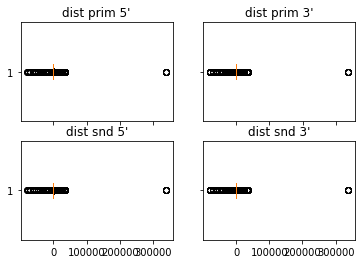

In [46]:
# look at distances
fig, axs = plt.subplots(2, 2)

axs[0, 0].boxplot(activity_score_df["dist prim 5'"], vert=False)
axs[0, 0].set_title("dist prim 5'")
axs[0, 1].boxplot(activity_score_df["dist prim 3'"], vert=False)
axs[0, 1].set_title("dist prim 3'")
axs[1, 0].boxplot(activity_score_df["dist snd 5'"], vert=False)
axs[1, 0].set_title("dist snd 5'")
axs[1, 1].boxplot(activity_score_df["dist snd 3'"], vert=False)
axs[1, 1].set_title("dist snd 3'")

for ax in fig.get_axes():
    ax.label_outer()

**TODO**: These boxplots suggest that there are several outliers among the distances. This may be because of incorrect annotations. Further investigation is necessary.

# Relationship between CRISPRi activity and sgRNA position relative to the TSS as predicted by SVR.

In [94]:
len(activity_score_df[activity_score_df["dist prim 3'"] < -100000])

0

In [123]:
tmp = activity_score_df[["dist prim 3'", "dist prim 5'", "dist snd 5'", "dist snd 3'", "score"]]
tmp = tmp[(tmp["dist prim 3'"] > -1500) & (tmp["dist prim 3'"] < 1500)]
tmp = tmp[(tmp["dist prim 5'"] > -1500) & (tmp["dist prim 5'"] < 1500)]
tmp = tmp[(tmp["dist snd 5'"] > -1500) & (tmp["dist snd 5'"] < 1500)]
tmp = tmp[(tmp["dist snd 3'"] > -1500) & (tmp["dist snd 3'"] < 1500)]
tmp.head()

,dist prim 3',dist prim 5',dist snd 5',dist snd 3',score
0,-20,-58,-19,22,0.019320
1,205,167,206,247,0.348892
2,125,87,126,167,0.912409
3,103,65,104,145,0.997242
4,59,21,60,101,0.962154


In [124]:
# SVR trained on an 80% division of the CRISPRi activity score dataset
# using the position of the sgRNA relative to the upstream end of TSS for each gene.

X3p = np.array(tmp["dist prim 3'"]).reshape(-1, 1)
X5p = np.array(tmp["dist prim 5'"]).reshape(-1, 1)
X3s = np.array(tmp["dist snd 3'"]).reshape(-1, 1)
X5s = np.array(tmp["dist snd 5'"]).reshape(-1, 1)
y = np.array(tmp['score'])

In [126]:
regr3p = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf'))
fit3p = regr3p.fit(X3p, y) 
print(fit3p.score(X3p, y))

regr5p = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf'))
fit5p = regr5p.fit(X5p, y) 
print(fit5p.score(X5p, y))

regr3s = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf'))
fit3s = regr3s.fit(X3s, y) 
print(fit3s.score(X3s, y))

regr5s = make_pipeline(StandardScaler(), svm.SVR(kernel='rbf'))
fit5s = regr5s.fit(X5s, y) 
print(fit5s.score(X5s, y))

0.015924884882130286
0.017134935176534194
-0.02637555915246459
-0.026731728058202453


In [ ]:
# Hyperparameter values for SVR were selected automatically using cross-validation 
# within the training set. 

In [ ]:
# param_grid = [
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
#  ]
# svr = svm.SVR()
# clf = GridSearchCV(svr, param_grid)
# model = clf.fit(X, y)
# model.score(X)
# model.get_params()

In [ ]:
# To display the relationship between sgRNA position and CRISPRi activity fit by this model, 
# predicted scores were generated for each position within a 3 kb window around the TSS. 
# Graph produced --> lets make it too!!!

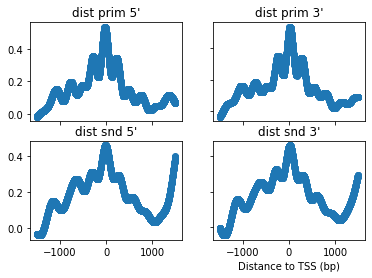

In [127]:
x_pseudo = np.arange(-1500, 1500)
y_pred3s = regr3s.predict(x_pseudo.reshape(-1, 1))
y_pred5s = regr5s.predict(x_pseudo.reshape(-1, 1))
y_pred3p = regr3p.predict(x_pseudo.reshape(-1, 1))
y_pred5p = regr5p.predict(x_pseudo.reshape(-1, 1))

fig, axs = plt.subplots(2, 2)
plt.xlabel('Distance to TSS (bp)')
plt.ylabel('SVR Fit Activity (arbitrary units)')

axs[0, 0].scatter(x_pseudo, y_pred5p)
axs[0, 0].set_title("dist prim 5'")
axs[0, 1].scatter(x_pseudo, y_pred3p)
axs[0, 1].set_title("dist prim 3'")
axs[1, 0].scatter(x_pseudo, y_pred5s)
axs[1, 0].set_title("dist snd 5'")
axs[1, 1].scatter(x_pseudo, y_pred3s)
axs[1, 1].set_title("dist snd 3'")

for ax in fig.get_axes():
    ax.label_outer()

In [140]:
y_pred3s = regr3s.predict(np.array(activity_score_df["dist snd 3'"]).reshape(-1, 1))
y_pred5s = regr5s.predict(np.array(activity_score_df["dist snd 5'"]).reshape(-1, 1))
y_pred3p = regr3p.predict(np.array(activity_score_df["dist prim 3'"]).reshape(-1, 1))
y_pred5p = regr5p.predict(np.array(activity_score_df["dist prim 5'"]).reshape(-1, 1))

In [141]:
d = {
    "dist prim 3'" : y_pred3p,
    "dist prim 5'" : y_pred5p,
    "dist snd 3'" : y_pred3s,
    "dist snd 5'" : y_pred5s
}
SVR_df = pd.DataFrame(data = d)
SVR_df

,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,0.469256,0.502084,0.462242,0.460538
1,0.252601,0.282746,0.280839,0.280037
2,0.291071,0.260337,0.282698,0.290886
3,0.357970,0.314729,0.305851,0.315995
4,0.494522,0.457831,0.375218,0.385287
5,0.241030,0.267910,0.276932,0.276765
6,0.247846,0.234311,0.271213,0.276959
7,0.405006,0.359012,0.325537,0.336301
8,0.369248,0.411021,0.448513,0.442444
9,0.389447,0.431084,0.453481,0.448091


{'whiskers': [<matplotlib.lines.Line2D at 0x7fc4e1066a20>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc4e1ba5160>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc4e10668d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc4e1ba5860>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc4e1ba5be0>],
 'means': []}

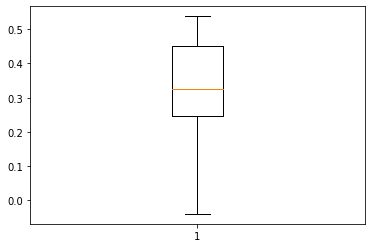

In [143]:
plt.boxplot(SVR_df["dist prim 3'"])

# Make Final Dataframes of all Features

In [173]:
activity_score_df_cols = [
    "+ve strand",
    "length",
    "longest A",
    "longest C",
    "longest G",
    "longest T"
]
activity_score_df_features = activity_score_df[activity_score_df_cols]

sgRNA_bases_cols = [
    "As",
    "Cs",
    "Gs",
    "Ts"
]
sgRNA_bases_features = sgRNA_bases[sgRNA_bases_cols]

sgRNA_dimers_cols = [
    "GC",
    "CA",
    "AG"
]
sgRNA_dimers_features = sgRNA_dimers[sgRNA_dimers_cols]

nucl_onehot_features = nucl_onehot.iloc[:, 0:(nucl_onehot.shape[1] - 1)]
dimer_onehot_features = dimer_onehot.iloc[:, 0:(dimer_onehot.shape[1] - 1)]

SVR_df_features = SVR_df

In [174]:
features_df_list = [
    activity_score_df_features, 
    sgRNA_bases_features, 
    sgRNA_dimers_features, 
    nucl_onehot_features, 
    dimer_onehot_features, 
    SVR_df_features
]
features_df = pd.concat(features_df_list, axis = 1)
features_df.head()

,+ve strand,length,longest A,longest C,longest G,longest T,As,Cs,Gs,Ts,...,pos_23_GC,pos_23_GG,pos_23_GT,pos_23_TA,pos_23_TC,pos_23_TG,dist prim 3',dist prim 5',dist snd 3',dist snd 5'
0,1,24,1,1,2,2,0.142857,0.238095,0.428571,0.190476,...,0,0,0,0,0,0,0.469256,0.502084,0.462242,0.460538
1,1,24,1,4,2,1,0.142857,0.476190,0.333333,0.047619,...,0,0,0,0,0,0,0.252601,0.282746,0.280839,0.280037
2,1,24,1,3,2,1,0.095238,0.380952,0.380952,0.142857,...,0,0,0,0,0,1,0.291071,0.260337,0.282698,0.290886
3,1,24,1,3,2,1,0.238095,0.238095,0.428571,0.095238,...,0,0,1,0,0,0,0.357970,0.314729,0.305851,0.315995
4,1,24,1,3,3,2,0.047619,0.285714,0.523810,0.142857,...,0,1,0,0,0,0,0.494522,0.457831,0.375218,0.385287
